In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statistics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pokemon-images-and-types/pokemon.csv
/kaggle/input/pokemon-images-and-types/images/images/fraxure.png
/kaggle/input/pokemon-images-and-types/images/images/chansey.png
/kaggle/input/pokemon-images-and-types/images/images/walrein.png
/kaggle/input/pokemon-images-and-types/images/images/yanma.png
/kaggle/input/pokemon-images-and-types/images/images/shuckle.png
/kaggle/input/pokemon-images-and-types/images/images/dunsparce.png
/kaggle/input/pokemon-images-and-types/images/images/kyogre.png
/kaggle/input/pokemon-images-and-types/images/images/whismur.png
/kaggle/input/pokemon-images-and-types/images/images/golurk.png
/kaggle/input/pokemon-images-and-types/images/images/flygon.png
/kaggle/input/pokemon-images-and-types/images/images/tranquill.png
/kaggle/input/pokemon-images-and-types/images/images/fomantis.jpg
/kaggle/input/pokemon-images-and-types/images/images/volcarona.png
/kaggle/input/pokemon-images-and-types/images/images/machoke.png
/kaggle/input/pokemon-images-and-type

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import datasets, transforms, utils
from sklearn import preprocessing
from skimage import io, transform, color, img_as_float32
import matplotlib.pyplot as plt
import PIL

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Using GPU: {}".format(use_cuda))

Using GPU: True


In [4]:
class PokemonDataset(Dataset):
    def __init__(self, transform=None):
        self.pokemon_data = pd.read_csv('/kaggle/input/pokemon-images-and-types/pokemon.csv')
        self.pokemon_data = self.pokemon_data.drop(columns=['Type2'])
        
        self.encoder = preprocessing.LabelEncoder()
        self.encoded_y = self.encoder.fit_transform(self.pokemon_data.Type1)
        
        self.transform = (transform != None)
        self.initial_transform = transform
        
    def __len__(self):
        return len(self.pokemon_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join('/kaggle/input/pokemon-images-and-types/images/images', self.pokemon_data.iloc[idx,0])
        if os.path.isfile(img_name+'.png'):
            image = PIL.Image.open(img_name+'.png').convert('RGB')
        else:
            image = PIL.Image.open(img_name+'.jpg')#.convert('RGB')
            
        if self.transform:
            image = self.initial_transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        pokemon_type = self.pokemon_data.iloc[idx,1]

        sample = {'image': image, 'name': self.pokemon_data.iloc[idx,0], 'type': int(self.encoded_y[idx]), 'typeName': pokemon_type}
        
        return sample
    
    def get_type_name(self, label):
        return self.encoder.inverse_transform(label)
    
    def disable_transforms(self):
        self.transform = None
        
    def enable_transforms(self):
        self.transform = True

In [5]:
# Define the hyper-parameters and other constants
EPOCHS = 200
BATCH_SIZE = 32
TRAIN_SIZE = 80 # % of the training dataset
POKEMON_TYPES = 18
SIZE_IMAGE = 120

In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=[-45,45], resample=PIL.Image.NEAREST), 
    transforms.ToTensor(),
])

pokemon_ds = PokemonDataset(transform)

split_point = int(TRAIN_SIZE*len(pokemon_ds)/100)
# training_ds, testing_ds = torch.utils.data.random_split(pokemon_ds, [split_point,len(pokemon_ds)-split_point], generator=torch.Generator().manual_seed(1))
training_ds, testing_ds = torch.utils.data.random_split(pokemon_ds, [split_point,len(pokemon_ds)-split_point])

pokemon_dataloader_train = DataLoader(testing_ds,  batch_size=32, shuffle=True)
pokemon_dataloader_test  = DataLoader(testing_ds,  batch_size=32, shuffle=False)

In [7]:
# class PokemonModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pokemon_model = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(32),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(64),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(64),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(128),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(256),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Flatten(),
#             nn.Linear(in_features=256, out_features=POKEMON_TYPES, bias=True)
#         )
        
#     def forward(self, x):
#         return self.pokemon_model(x)

In [8]:
# class PokemonModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pokemon_model = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(32),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(32),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(32),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.BatchNorm2d(64),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(64),
#             nn.Dropout(p=0.5),
#             nn.ReLU(inplace=True),
            
#             nn.Flatten(),
#             nn.Linear(in_features=64, out_features=POKEMON_TYPES, bias=True)
#         )
        
#     def forward(self, x):
#         return self.pokemon_model(x)

In [9]:
class PokemonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.pokemon_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=0, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(4),
            nn.Dropout(p=0.10),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=0, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.10),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.10),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.10),
            nn.ReLU(inplace=True),
            
            nn.Flatten(),
            nn.Linear(in_features=2592, out_features=POKEMON_TYPES, bias=True)
        )
        
    def forward(self, x):
        return self.pokemon_model(x)

In [10]:
def loss_function(pred, y):
    return F.cross_entropy(pred,y)

In [11]:
def test(model, testing_dataset):
    model.eval()
    pokemon_ds.disable_transforms()
    
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in testing_dataset:
            x_test = batch['image'].to(device=device, dtype=torch.float32)
            y_test = batch['type'].to(device=device, dtype=torch.long)
            
            results = model(x_test)
            _,preds = results.max(1)
            
            correct_preds += (preds==y_test).sum()
            total_preds += preds.size(0)
    
    print("Correct predictions={}/{}. Accuracy={:.2f}%.".format(correct_preds,total_preds, 100.0*correct_preds/total_preds))

In [12]:
validation_losses = []
def evaluate(model, evaluation_dataset):
    model.eval()
    pokemon_ds.disable_transforms()
    
    losses = []
    with torch.no_grad():
        for batch in evaluation_dataset:
            x_validate = batch['image'].to(device=device, dtype=torch.float32)
            y_validate = batch['type'].to(device=device, dtype=torch.long)
    
            preds = model(x_validate)
        
            loss = loss_function(preds, y_validate)
            losses.append(loss.item())
            
    validation_losses.append(statistics.mean(losses))

In [13]:
training_losses = []
def training(model, optimiser):
    
    for epoch in range(EPOCHS):
        losses = []
        for i, batch in enumerate(pokemon_dataloader_train):
            model.train()
            
            x_train = batch['image'].to(device=device, dtype=torch.float32)
            y_train = batch['type'].to(device=device, dtype=torch.long)
            
            preds = model(x_train)
            
            loss = loss_function(preds,y_train)
            losses.append(loss.item())
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
        training_losses.append(statistics.mean(losses))
        print("Epoch {}, Training loss={}.".format(epoch+1,training_losses[-1]))
        
        evaluate(model, pokemon_dataloader_test)
        pokemon_ds.enable_transforms()

In [14]:
pModel = PokemonModel()
pModel = pModel.to(device=device)

optimiser = optim.Adam(pModel.parameters())

training(pModel, optimiser)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1, Training loss=3.0009181102116904.
Epoch 2, Training loss=2.806610584259033.
Epoch 3, Training loss=2.4867013692855835.
Epoch 4, Training loss=2.7018947998682656.
Epoch 5, Training loss=2.6065572102864585.
Epoch 6, Training loss=2.399187207221985.
Epoch 7, Training loss=2.4442058801651.
Epoch 8, Training loss=2.3336512645085654.
Epoch 9, Training loss=2.227972388267517.
Epoch 10, Training loss=2.290512522061666.
Epoch 11, Training loss=2.252544562021891.
Epoch 12, Training loss=2.115012764930725.
Epoch 13, Training loss=2.110231041908264.
Epoch 14, Training loss=2.026849647363027.
Epoch 15, Training loss=2.2590025067329407.
Epoch 16, Training loss=2.0783673524856567.
Epoch 17, Training loss=2.1814233462015786.
Epoch 18, Training loss=1.8525351881980896.
Epoch 19, Training loss=1.9083659648895264.
Epoch 20, Training loss=2.130045692125956.
Epoch 21, Training loss=1.9010736147562664.
Epoch 22, Training loss=2.0101414918899536.
Epoch 23, Training loss=1.925199826558431.
Epoch 24, 

Epoch 187, Training loss=0.7343700975179672.
Epoch 188, Training loss=0.6623134811719259.
Epoch 189, Training loss=0.8941045006116232.
Epoch 190, Training loss=0.5268678913513819.
Epoch 191, Training loss=0.6319360087315241.
Epoch 192, Training loss=0.5426287551720937.
Epoch 193, Training loss=0.5646181404590607.
Epoch 194, Training loss=1.0779503633578618.
Epoch 195, Training loss=0.5281226138273875.
Epoch 196, Training loss=0.5784888664881388.
Epoch 197, Training loss=0.8167795091867447.
Epoch 198, Training loss=0.5030650198459625.
Epoch 199, Training loss=0.5373556713263193.
Epoch 200, Training loss=0.8765447785456976.


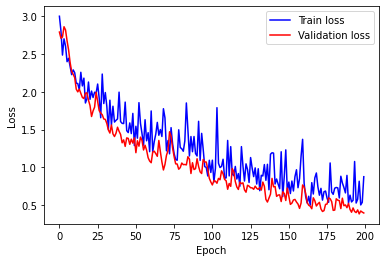

In [15]:
plt.plot(training_losses, 'b')
plt.plot(validation_losses, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'])
plt.show()

In [16]:
test(pModel, pokemon_dataloader_test)

Correct predictions=146/162. Accuracy=90.12%.


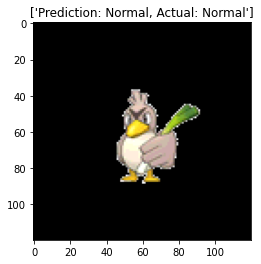

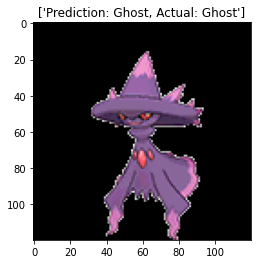

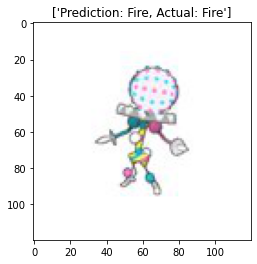

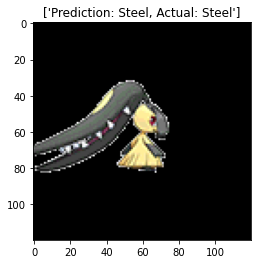

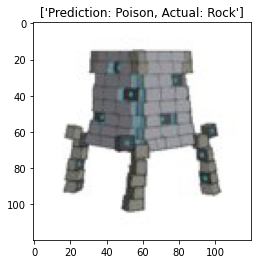

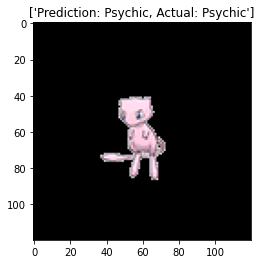

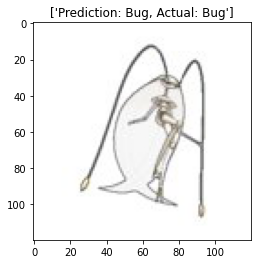

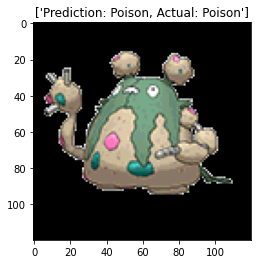

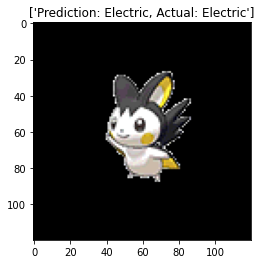

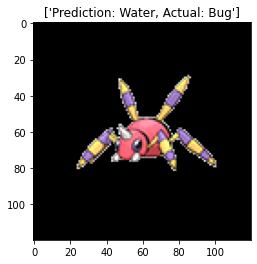

In [20]:
pokemon_ds.disable_transforms()
pModel.eval()
for idx in range(10):
    x = testing_ds[idx]['image'].to(device=device, dtype=torch.float32)
    
    pred_logits = pModel(x.unsqueeze(0))
    pred =  int(torch.argmax(pred_logits).item())
    
    plt.figure(idx)
    plt.title('Prediction: '+pokemon_ds.get_type_name( [pred] )+', Actual: '+testing_ds[idx]['typeName'])
    plt.imshow( x.permute(1, 2, 0).cpu() )